# Compute the partition function by tensor contraction

In [1]:
import torch
import numpy as np
import numba as nb
from scipy.linalg import sqrtm

In [2]:
import math
import time
from tqdm.auto import trange

In [3]:
import pickle

In [4]:
import matplotlib.pyplot as plt

---------------------------------
### Chain Cluster

In [5]:
global grid, dims, beta, j, h

In [6]:
def parameters_init(dims_init, beta_init, j_init, h_init):
    global grid, dims, beta, j, h
    #global dims, beta, j, h
    dims = (nb.int8(dims_init[0]), nb.int8(dims_init[1]))
    beta, j, h = nb.float64(beta_init), nb.int8(j_init), nb.int8(h_init)
    grid = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                        size=dims_init[0]*dims_init[1]), dims_init)

In [7]:
np.random.seed(0)
dims_init = (4, 4)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0
parameters_init(dims_init, beta_init, j_init, h_init)

In [7]:
np.random.seed(0)
dims_init = (8, 8)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0
parameters_init(dims_init, beta_init, j_init, h_init)

In [7]:
np.random.seed(0)
dims_init = (16, 16)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0
parameters_init(dims_init, beta_init, j_init, h_init)

In [7]:
np.random.seed(0)
dims_init = (32, 32)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0
parameters_init(dims_init, beta_init, j_init, h_init)

In [8]:
@nb.njit
def copy_tensor_create():
    I_2_array = np.zeros((2, 2), dtype=np.int8)
    I_3_array = np.zeros((2, 2, 2), dtype=np.int8)
    I_4_array = np.zeros((2, 2, 2, 2), dtype=np.int8)
    I_up_array = np.zeros((2, 2, 2, 2), dtype=np.int8)
    I_down_array = np.zeros((2, 2, 2, 2), dtype=np.int8)
    for i in range(2):
        I_2_array[i, i] = 1
        I_3_array[i, i, i] = 1
        I_4_array[i, i, i, i] = 1
    I_up_array[0][0][0][0] = 1
    I_down_array[1][1][1][1] = 1
    I_1_array = np.ones(2, dtype=np.int8)
    return I_1_array, I_2_array, I_3_array, I_4_array, I_up_array, I_down_array

In [9]:
@nb.njit
def vec_mat_mul(vec_array, mat_array):
    dim_mat = mat_array.shape[0]
    dim_vec = mat_array.shape[1]
    vec_new = np.zeros(dim_vec, dtype=np.float64)
    for i in range(dim_mat):
        vec_new += vec_array[i] * mat_array[i, :]
    return vec_new

In [10]:
def node_tensor_create():
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create()
    #B = torch.tensor(sqrtm(np.array([[np.exp(beta*j),np.exp(-beta*j)], 
    #                                 [np.exp(-beta*j),np.exp(beta*j)]])), 
    #                 dtype=torch.float64, device=my_device)
    B = 1/2 * np.array([[math.sqrt(2 * math.cosh(beta * j)) + math.sqrt(2 * math.sinh(beta * j)), 
                         math.sqrt(2 * math.cosh(beta * j)) - math.sqrt(2 * math.sinh(beta * j))], 
                        [math.sqrt(2 * math.cosh(beta * j)) - math.sqrt(2 * math.sinh(beta * j)), 
                         math.sqrt(2 * math.cosh(beta * j)) + math.sqrt(2 * math.sinh(beta * j))]], 
                       dtype=np.float64)
    A_1 = np.einsum("i, ij -> j", I_1, B)
    A_2 = np.einsum("ij, ab, jb -> ia", B, B, I_2)
    A_3 = np.einsum("ij, kl, mn, jln -> ikm", B, B, B, I_3)
    A_4 = np.einsum("ij, kl, mn, pq, jlnq -> ikmp", B, B, B, B, I_4)
    spin_up = np.array([1, 0], dtype=np.float64)
    spin_down = np.array([0, 1], dtype=np.float64)
    spin_up = np.einsum("i, ij -> j", spin_up, B)
    spin_down = np.einsum("i, ij -> j", spin_down, B)
    return A_1, A_2, A_3, A_4, B, spin_up, spin_down

In [11]:
global I_1, I_2, I_3, I_4, I_up, I_down

In [12]:
global A_1, A_2, A_3, A_4, B, spin_up, spin_down

In [13]:
def tensors_init():
    global I_1, I_2, I_3, I_4, I_up, I_down
    global A_1, A_2, A_3, A_4, B, spin_up, spin_down
    global tensors_array
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create()
    A_1, A_2, A_3, A_4, B, spin_up, spin_down = node_tensor_create()
    tensors_array = np.array([A_4 for _ in range(dims[1])], dtype=np.float64)

In [14]:
tensors_init()

In [15]:
type_bdy_array_prepare_fun = nb.types.UniTuple(nb.float64[:, :], 2)(nb.int8[:, :], nb.int8)
@nb.njit(type_bdy_array_prepare_fun)
def bdy_array_prepare(grid, row_id):
    row_id_up = (row_id - 1) % dims[0]
    row_id_down = (row_id + 1) % dims[0]
    up_bdy_array = np.zeros((2, dims[1]), dtype=np.float64)
    down_bdy_array = np.zeros((2, dims[1]), dtype=np.float64)
    for i in range(dims[1]):
        up_bdy_array[:, i] = (grid[row_id_up][i] + 1) / 2 * B[0] + (1 - grid[row_id_up][i]) / 2 * B[1]
        down_bdy_array[:, i] = (grid[row_id_down][i] + 1) / 2 * B[0] + (1 - grid[row_id_down][i]) / 2 * B[1]
    return up_bdy_array, down_bdy_array

In [16]:
type_fourway_vec_vec_my_func = nb.float64[:, :](nb.float64[:, :, :, :], nb.float64[:], nb.float64[:])
#@nb.njit(type_fourway_vec_vec_my_func)
@nb.njit
def fourway_vec_vec_my(A_ijkl, u_j, v_l):
    i, j, k, l = A_ijkl.shape
    B_ik = np.zeros((i, k), dtype=np.float64)
    for ii in range(i):
        for kk in range(k):
            for jj in range(j):
                for ll in range(l):
                    B_ik[ii][kk] += A_ijkl[ii][jj][kk][ll] * u_j[jj] * v_l[ll]
    return B_ik

In [17]:
#type_tensors_array_prepare_nb_func = nb.float64[:, :, :](nb.float64[:, :], nb.float64[:, :])
#@nb.njit(type_tensors_array_prepare_nb_func)
@nb.njit
def tensors_array_prepare_nb(up_bdy_array, down_bdy_array):
    tensors_array = np.zeros((dims[1], 2, 2), dtype=np.float64)
    for i in range(dims[1]):
        tensor_i = fourway_vec_vec_my(A_4, down_bdy_array[:, i], up_bdy_array[:, i])
        tensors_array[i] = tensor_i
    return tensors_array

In [18]:
@nb.njit
def mat_vec_my(B_ij, v_j):
    i, j = B_ij.shape
    u_i = np.zeros(i, dtype=np.float64)
    for jj in range(j):
        u_i += B_ij[:, jj] * v_j[jj]
    return u_i

In [19]:
@nb.njit
def mat_mat_my(B_ij, u_jk):
    i, j = B_ij.shape
    j, k = u_jk.shape
    uu_ik = np.zeros((i, k), dtype=np.float64)
    for ii in range(i):
        for jj in range(j):
            for kk in range(k):
                uu_ik[ii][kk] += B_ij[ii, jj] * u_jk[jj, kk]
    return uu_ik

In [20]:
@nb.njit
def z_four_edge_create(B_in, T_nj, B_l, B_m):
    i, n = B_in.shape
    n, j = T_nj.shape
    j, k = i, n
    l, m = 2, 2
    z_four_edge = np.zeros((i, k, l, m), dtype=np.float64)
    for ii in range(i):
        for nn in range(n):
            for jj in range(j):
                for kk in range(k):
                    for ll in range(l):
                        for mm in range(m):
                            z_four_edge[ii, kk, ll, mm] += (B_in[ii][nn] * T_nj[nn][jj] * B_in[jj][kk] * B_l[ll] * B_m[mm])
    return z_four_edge

In [21]:
@nb.njit
def chain_one_row(grid, row_id, tensors_array, up_bdy_array, down_bdy_array):
    start_id = 0
    end_id = dims[1] - 1
    up_row_id = (row_id - 1) % dims[0]
    down_row_id = (row_id + 1) % dims[0]
    #########################################################
    spin_up_bdy = up_bdy_array[:, start_id]
    spin_down_bdy = down_bdy_array[:, start_id]
    #B_up = torch.einsum("ij, j -> i", [B, spin_up_bdy])
    B_up = mat_vec_my(B, spin_up_bdy)
    #B_down = torch.einsum("ij, j -> i", [B, spin_down_bdy])
    B_down = mat_vec_my(B, spin_down_bdy)
    #########################################################
    tensor_start = tensors_array[start_id+1]
    tensors_stack = np.zeros((dims[1] - 1, tensor_start.shape[0], tensor_start.shape[1]), 
                             dtype=np.float64)
    tensors_stack[0] = tensor_start
    for i in range(2, dims[1]):
        #tensor_start = torch.einsum("ij, jk -> ik", [tensor_start, 
        #                                             tensors_list[i]])
        tensor_start = mat_mat_my(tensor_start, tensors_array[i])
        tensors_stack[i-1] = tensor_start
        #print(tensor_start)
        #tensors_stack.append(tensor_start)
    #z_four_edge = torch.einsum("in, nj, jk, l, m -> iklm", [B, tensor_start,
    #                                                        B, B_up, B_down])
    z_four_edge = z_four_edge_create(B, tensor_start, B_up, B_down)
    #print(z_four_edge)
    z_up = z_four_edge[0][0][0][0]
    z_down = z_four_edge[1][1][1][1]
    #z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up]) 
    #z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])                         
    z = z_up + z_down
    prob_up = z_up / z
    prob_random = np.random.random()
    if prob_random < prob_up:
        grid[row_id][start_id] = 1
    else:
        grid[row_id][start_id] = -1
    return tensors_stack, grid, z

In [22]:
@nb.njit
def z_four_edge_backtrack(l_bdy, s_tensor, B, u_bdy, d_bdy, r_bdy):
    i = l_bdy.shape[0]
    _, j = s_tensor.shape
    _, l = B.shape
    o, m = j, l
    p, n = j, l
    r, k = B.shape
    z_four_edge = np.zeros((l, m, n, k), dtype=np.float64)
    for ii in range(i):
        for jj in range(j):
            for ll in range(l):
                for oo in range(o):
                    for mm in range(m):
                        for pp in range(p):
                            for nn in range(n):
                                for rr in range(r):
                                    for kk in range(k):
                                        z_four_edge[ll, mm, nn, kk] += (l_bdy[ii] * s_tensor[ii, jj] * 
                                                                        B[jj, ll] * B[oo, mm] * u_bdy[oo] *
                                                                        B[pp, nn] * d_bdy[pp] * B[rr, kk] * 
                                                                        r_bdy[rr])
    return z_four_edge

In [23]:
@nb.njit
def z_four_edge_backtrack_end(u_bdy, d_bdy, l_bdy, r_bdy, B):
    i, j, k, l = u_bdy.shape[0], d_bdy.shape[0], l_bdy.shape[0], r_bdy.shape[0]
    i, m = B.shape
    j, n = i, m
    k, o = i, m
    l, p = i, m
    z_four_edge = np.zeros((m, n, o, p), dtype=np.float64)
    for ii in range(i):
        for jj in range(j):
            for kk in range(k):
                for ll in range(l):
                    for mm in range(m):
                        for nn in range(n):
                            for oo in range(o):
                                for pp in range(p):
                                    z_four_edge[mm, nn, oo, pp] += (u_bdy[ii] * d_bdy[jj] * l_bdy[kk] * 
                                                                    r_bdy[ll] * B[ii, mm] * B[jj, nn] * 
                                                                    B[kk, oo] * B[ll, pp])
    return z_four_edge

In [24]:
@nb.njit
def backtrack(grid, start_id, row_id, tensors_stack, 
              up_bdy_array, down_bdy_array):
    #tensors_stack.pop()
    left_bdy = spin_up if grid[row_id][start_id] == 1 else spin_down
    for i in range(dims[1]-2):
        right_bdy = spin_up if grid[row_id][start_id] == 1 else spin_down
        start_id = (start_id - 1) % dims[1]
        down_bdy, up_bdy = down_bdy_array[:, start_id], up_bdy_array[:, start_id]
        start_tensor = tensors_stack[-(i+2)]
        z_four_edge = z_four_edge_backtrack(left_bdy, start_tensor, B, 
                                            up_bdy, down_bdy, right_bdy)
        #z_four_edge = torch.einsum("i, ij, jl, om, o, pn, p, rk, r -> lmnk", 
        #                           [left_bdy, start_tensor, B, B,
        #                            up_bdy, B, down_bdy, B, right_bdy])
        #z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        #z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        z_up = z_four_edge[0, 0, 0, 0]
        z_down = z_four_edge[1, 1, 1, 1]
        z = z_up + z_down
        #print(z)
        prob_up = z_up / z
        prob_random = np.random.random()
        if prob_random < prob_up:
            grid[row_id][start_id] = 1
        else:
            grid[row_id][start_id] = -1
    up_bdy, down_bdy = up_bdy_array[:, start_id-1], down_bdy_array[:, start_id-1]
    right_bdy = spin_up if grid[row_id][start_id] == 1 else spin_down
    #z_four_edge = torch.einsum("i, j, k, l, im, jn, ko, lp -> mnop", [up_bdy, down_bdy,
    #                                                                  left_bdy, right_bdy,
    #                                                                  B, B, B, B])
    z_four_edge = z_four_edge_backtrack_end(up_bdy, down_bdy, left_bdy, right_bdy, B)
    #z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    #z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    z_up = z_four_edge[0, 0, 0, 0]
    z_down = z_four_edge[1, 1, 1, 1]
    z = z_up + z_down
    #print(z)
    prob_up = z_up / z
    prob_random = np.random.random()
    if prob_random < prob_up:
        grid[row_id][start_id-1] = 1
    else:
        grid[row_id][start_id-1] = -1    
    return grid

In [25]:
types_neibors_get_square_func = nb.types.UniTuple(nb.types.UniTuple(nb.int8, 2), 4)(nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibors_get_square_func)
def neibors_get_square(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    l_neibor = (height_index, (width_index - 1) % width)
    r_neibor = (height_index, (width_index + 1) % width)
    u_neibor = ((height_index - 1) % height, width_index)
    d_neibor = ((height_index + 1) % height, width_index)
    return (l_neibor, r_neibor, u_neibor, d_neibor)

In [26]:
@nb.njit(nb.float64(nb.int8[:, :]))
def energy_compute_grid(grid):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibors_get_square((nb.int8(ii), nb.int8(jj)))
            for ij in id_neibors:
                energy_ij = -1.0 / 2.0 * j * grid[ij[0]][ij[1]] * grid[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grid[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [27]:
@nb.njit(nb.float64(nb.int8[:, :]))
def magnet_grid(grid):
    m_mean = np.mean(grid)
    return m_mean

In [28]:
@nb.njit
def chain_sampling_one_step(grid):
    start_id = 0
    for i in range(dims[0]):
        up_bdy_array, down_bdy_array = bdy_array_prepare(grid, i)
        tensors_array = tensors_array_prepare_nb(up_bdy_array, down_bdy_array)
        tensors_stack, grid, _ = chain_one_row(grid, i, tensors_array, 
                                               up_bdy_array, down_bdy_array)
        grid = backtrack(grid, start_id, i, tensors_stack, up_bdy_array, down_bdy_array)
    return grid         

In [29]:
@nb.njit
def chain_evolution(grid, num_steps):
    energy_history = np.zeros(num_steps, dtype=np.float64)
    m_history = np.zeros(num_steps, dtype=np.float64)
    for i in range(num_steps):
        grid = chain_sampling_one_step(grid)
        energy_per_spin = energy_compute_grid(grid)
        m_per_spin = magnet_grid(grid)
        energy_history[i] = energy_per_spin
        m_history[i] = m_per_spin
    return grid, energy_history, m_history

In [30]:
### function used to check the chain evolution
def chain_message_passing(grid, id_row, id_start, id_end):
    id_up_row = (id_row - 1) % dims[0]
    id_down_row = (id_row + 1) % dims[0]
    left_id = (id_start - 1) % dims[1]
    energy_up = -j * (grid[id_up_row][id_start] + grid[id_row][left_id] + grid[id_down_row][id_start])
    energy_down = -1 * energy_up
    infor_node = np.exp([-beta * energy_up, -beta * energy_down])
    infor_edge = np.exp([[beta, -beta], [-beta, beta]])
    for i in range(id_start+1, id_end+1):
        energy_up_i = -j * (grid[id_up_row][i] + grid[id_down_row][i])
        energy_down_i = -1 * energy_up_i
        infor_node_orig = np.exp([-beta * energy_up_i, -beta * energy_down_i])
        infor_node = np.dot(infor_node, infor_edge)
        infor_node = infor_node * infor_node_orig
    if (id_end + 1) == dims[1]:
        energy_up_end = -j * grid[id_row][0]
    else:
        energy_up_end = -j * grid[id_row][id_end+1]
    energy_down_end = -1 * energy_up_end
    infor_node_end = np.exp([-beta * energy_up_end, -beta * energy_down_end])
    infor_node = infor_node * infor_node_end
    z = np.sum(infor_node)
    return infor_node, z

In [31]:
def z_compute_full(grid, row_id):
    up_row_id = (row_id - 1) % dims[0]
    down_row_id = (row_id + 1) % dims[0]
    z = 0
    for s1 in [1, -1]:
        for s2 in [1, -1]:
            for s3 in [1, -1]:
                for s4 in [1, -1]:
                    for s5 in [1, -1]:
                        energy_1 = -j * (s5 * s1 / 2 + s1 * s2 / 2 + s1 * grid[up_row_id][0] + 
                                         s1 * grid[down_row_id][0])
                        energy_2 = -j * (s2 * s3 / 2 + s2 * s1 / 2 + s2 * grid[up_row_id][1] + 
                                         s2 * grid[down_row_id][1])
                        energy_3 = -j * (s3 * s4 / 2 + s3 * s2 / 2  + s3 * grid[up_row_id][2] + 
                                         s3 * grid[down_row_id][2])
                        energy_4 = -j * (s4 * s5 / 2 + s4 * s3 / 2 + s4 * grid[up_row_id][3] + 
                                         s4 * grid[down_row_id][3])
                        energy_5 = -j * (s5 * s1 / 2 + s4 * s5 / 2 + s5 * grid[up_row_id][4] + 
                                         s5 * grid[down_row_id][4])
                        energy_total = energy_1 + energy_2 + energy_3 + energy_4 + energy_5
                        z_part = np.exp(-beta * energy_total)
                        z += z_part      
    return z

In [32]:
def spin_viz(figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grid*np.pi/2)
    v = np.sin(grid*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

--------------------
## Postive J
### Size = 4

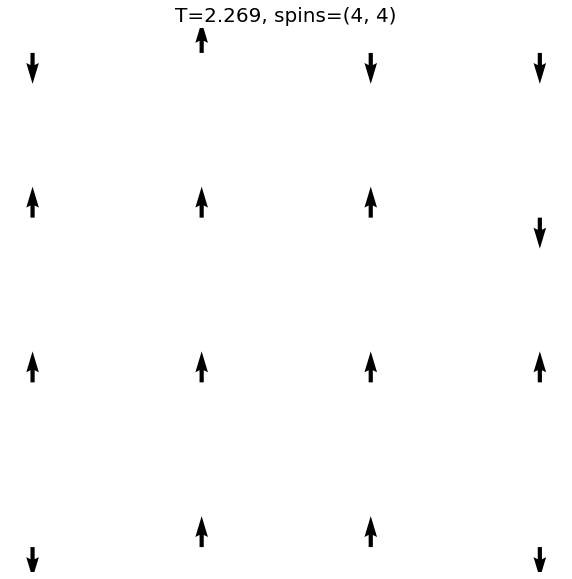

In [33]:
spin_viz()

In [34]:
### Burn-in stage
num_steps = 1000000
time_start = time.time()
grid, energy_history, m_history = chain_evolution(grid, num_steps)
time_end = time.time()
print(f"Time used for {num_steps} steps is: {time_end-time_start:.3f}.")

Time used for 1000000 steps is: 106.275.


In [35]:
np.mean(np.abs(m_history))

0.844273125

In [ ]:
### Sampling stage
num_steps = 10000000
time_start = time.time()
grid, energy_history, m_history = chain_evolution(grid, num_steps)
time_end = time.time()
print(f"Time used for {num_steps} steps is: {time_end-time_start:.3f}.")

In [ ]:
with open(f"../data_2d_ising/ising2d_size_{dims[0]}_beta_{beta:.3f}_tensor_1E7_m.pkl", "wb") as file:
    pickle.dump(m_history, file)

---------------------------
### Size = 8

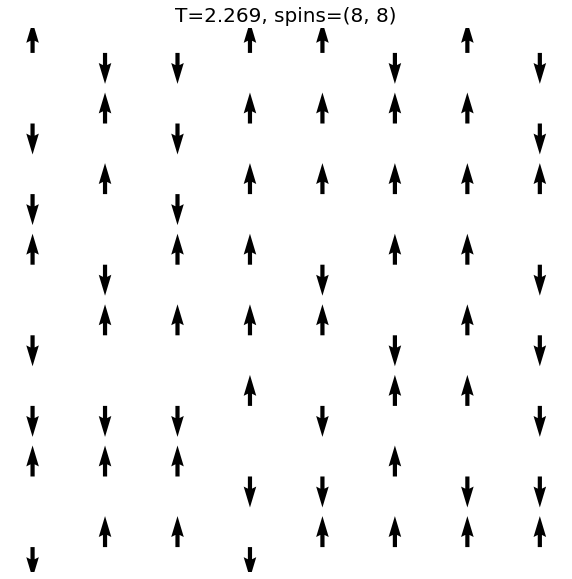

In [33]:
spin_viz()

In [34]:
### Burn-in stage
time_start = time.time()
num_steps = 1000000
grid, energy_history, m_history = chain_evolution(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

Time used for 1E5 steps is: 433.5838041305542.


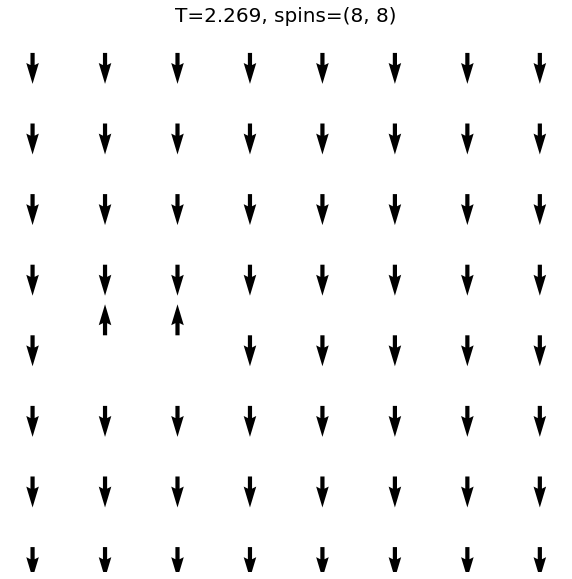

In [35]:
spin_viz()

In [37]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}")

The magnitization is: 0.77747940625


In [ ]:
### Sampling stage
num_steps = 10000000
time_start = time.time()
grid, energy_history, m_history = chain_evolution(grid, num_steps)
time_end = time.time()
print(f"Time used for {num_steps} steps is: {time_end-time_start:.3f}.")

In [ ]:
with open(f"../data_2d_ising/ising2d_size_{dims[0]}_beta_{beta:.3f}_tensor_1E7_m.pkl", "wb") as file:
    pickle.dump(m_history, file)

--------------------------
### Size = 16

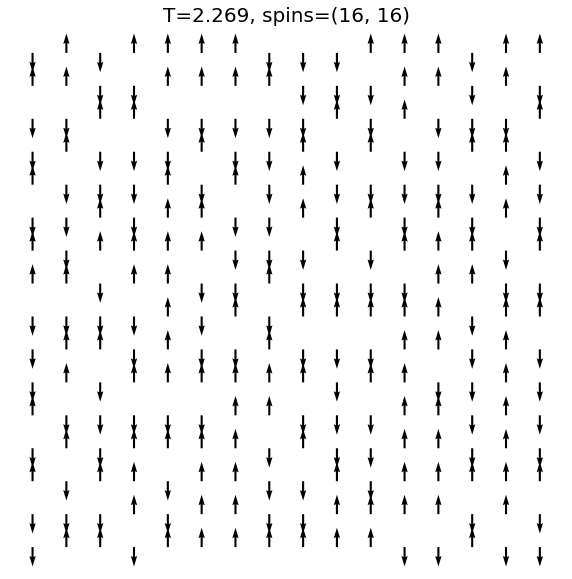

In [33]:
spin_viz()

In [34]:
### Burn-in stage
time_start = time.time()
num_steps = 1000000
grid, energy_history, m_history = chain_evolution(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

Time used for 1E5 steps is: 1900.9417130947113.


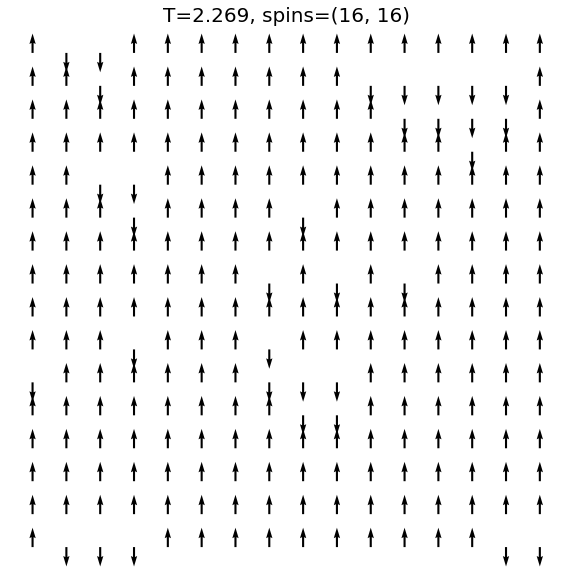

In [35]:
spin_viz()

In [37]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean:.3f}")

The magnitization is: 0.715


In [ ]:
### Sampling stage
num_steps = 10000000
time_start = time.time()
grid, energy_history, m_history = chain_evolution(grid, num_steps)
time_end = time.time()
print(f"Time used for {num_steps} steps is: {time_end-time_start:.3f}.")

In [ ]:
with open(f"../data_2d_ising/ising2d_size_{dims[0]}_beta_{beta:.3f}_tensor_1E7_m.pkl", "wb") as file:
    pickle.dump(m_history, file)

-------------------
### Size = 32

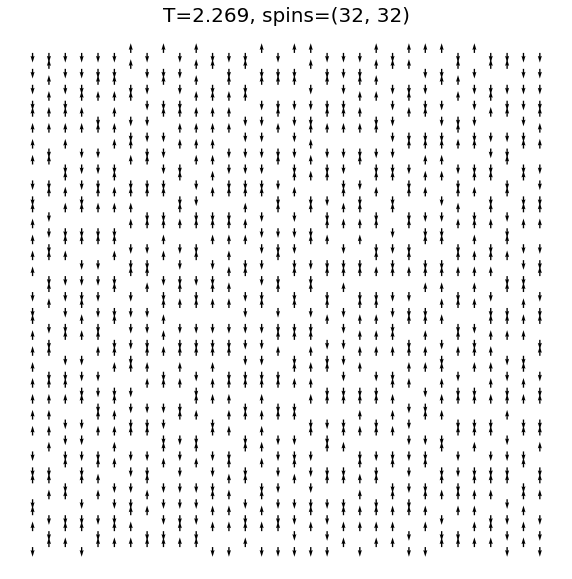

In [33]:
spin_viz()

In [34]:
### Burn-in stage
time_start = time.time()
num_steps = 1000000
grid, energy_history, m_history = chain_evolution(grid, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

Time used for 1E5 steps is: 4428.672656297684.


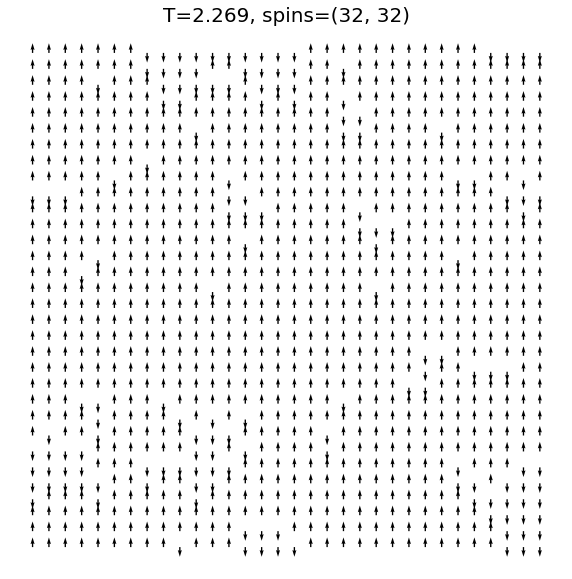

In [35]:
spin_viz()

In [36]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean:.3f}")

The magnitization is: 0.655
